In [3]:
''' Please remove this cell when running in local context'''
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
from torchtext import *
from torchtext.data import *
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Preprocess Data and sanity check



In [5]:
# Define stopwords so that we can remove it from textfield
stop_words = set(stopwords.words('english'))   

# Define text and labael fields 
txt_field = data.Field(tokenize=word_tokenize, lower=True, include_lengths=True, batch_first=True, stop_words = stop_words)          
label_field = data.Field(sequential=False, use_vocab=False, batch_first=True)


''' 
in local context where this notebook is in the same folder as csv files, please change the path
-> path = './' 
'''
path = '/content/drive/My Drive/4211_ass2_data/part2/'        
#path = './' 

train, val, test= TabularDataset.splits(path=path, train='train.csv', validation='validation.csv', test='test.csv',      
                                        format='csv',fields=[('label', label_field),('text', txt_field)], skip_header=True)      

print("Data size sanity check:")
print("Train: {}".format(len(train.examples)))
print("Val: {}".format(len(val.examples)))
print("Test: {}".format(len(test.examples)))

Data size sanity check:
Train: 40000
Val: 5000
Test: 3000


### Build vocabulary and define iterators 

In [6]:
txt_field.build_vocab(train, min_freq=5)          
label_field.build_vocab(train)                     

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)

train_iter, val_iter, test_iter = data.BucketIterator.splits((train, val, test), batch_size=32, device = device,
                                                   sort_key=lambda x: len(x.text),sort_within_batch=True)

Device:  cuda


In [7]:
print('Sample training data:\n {}\n'.format(vars(train.examples[0])))
print('Sample valid. data:\n {}\n'.format(vars(val.examples[0])))

Sample training data:
 {'label': '1', 'text': ['guess', 'one-sided', 'relationship', 'sort', 'able', 'identify', 'lead', 'character', 'minako', 'yuko', 'tanaka', ',', '50', 'year', 'old', 'woman', 'still', 'pink', 'good', 'health', ',', 'demonstrated', 'daily', ',', 'grinding', 'routine', 'waking', 'extremely', 'early', 'morning', 'prepare', 'milk', 'delivery', 'work', ',', 'lug', 'bottles', 'megmilk', 'bag', 'route', 'around', 'town', 'like', 'clockwork', ',', 'exchange', 'empty', 'bottles', 'full', 'ones', ',', 'collect', 'payment', 'issue', 'receipt', '.', "'s", 'always', 'one', 'delivery', 'stop', "'s", 'right', 'top', ',', 'needing', 'scale', 'long', 'flight', 'stairs', 'order', 'achieve', 'customer', 'satisfaction', '.', 'peculiar', 'enough', ',', 'stop', 'happened', 'stop', 'delivering', 'man', 'love', 'almost', 'teenage', 'adult', 'life', ',', 'product', 'appreciated', ',', 'poured', 'sink', '.', 'gone', 'school', ',', 'see', "'re", 'talking', ',', 'daily', 'life', 'always', 's

### Recurrent Network Model

Constructor takes model number as input and configures the model accordingly

In [ ]:
class Sentiment_RNN(nn.Module):
    def __init__(self, num_vocab, embedding_dim, num_hidden, num_layers, dropout_rate, pad_index, model_no):
        super(Sentiment_RNN, self).__init__()

        self.model_no = model_no
        assert self.model_no in [0,1,2,3,4] 
        
        #n_vocab = input dimension
        if self.model_no is not 4:
            self.emb = nn.Embedding(num_vocab, embedding_dim, padding_idx = pad_index)
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.num_vocab = num_vocab

        if self.model_no is 0: # Vanilla RNN
            self.rnn = nn.RNN(
                    input_size=embedding_dim,
                    hidden_size=num_hidden,
                    num_layers=num_layers,
                    dropout=dropout_rate,
                    batch_first=True
            ).cuda()
        elif self.model_no is 1: # GRU
            self.rnn = nn.GRU(
                    input_size=embedding_dim,
                    hidden_size=num_hidden,
                    num_layers=num_layers,
                    dropout=dropout_rate,
                    batch_first=True
            ).cuda()
        elif self.model_no is 2: # LSTM
            self.rnn = nn.LSTM(
                    input_size=embedding_dim,
                    hidden_size=num_hidden,
                    num_layers=num_layers,
                    dropout=dropout_rate,
                    batch_first=True
            ).cuda()
        elif self.model_no is 3: # LSTM + Bidirectional 
            self.rnn = nn.LSTM(
                    input_size=embedding_dim,
                    hidden_size=num_hidden,
                    num_layers=num_layers,
                    dropout=dropout_rate,
                    bidirectional = True,
                    batch_first=True
            ).cuda()
            num_hidden *= 2

        elif self.model_no is 4: # LSTM + No embedding
            self.rnn = nn.LSTM(
                    input_size=1,
                    hidden_size=num_hidden,
                    num_layers=num_layers,
                    dropout=dropout_rate,
                    batch_first=True
            ).cuda()
        
        self.fc = nn.Linear(num_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, sent, sent_len):

        if self.model_no is not 4:
            sent = self.dropout(self.emb(sent))
        else: # No embedding, directly feed raw integer values
            sent = sent.unsqueeze(-1).type(torch.float) 

        # pad the sequence
        packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len, batch_first=True)

        if self.model_no is 0 or self.model_no is 1:  #if vanilla or gru
            packed_outputs, hidden = self.rnn(packed)
        else:                                          # if lstm, which returns tuple
            packed_outputs, (hidden,cell) = self.rnn(packed)

        # Unpacking process, but no need for this task 
        # outputs, output_len = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        hidden = hidden.squeeze(0)

        if self.model_no is 3: #bidirectional, need to consider both forward and backward final hidden result
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        out = self.sigmoid(self.fc(self.dropout(hidden)))
        return out

    def extract_embedding(self, word):
        assert self.model_no is not 4
        return self.emb(word)

### Saving and Loading helper functions 

In [ ]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}
    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer, save_path):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

#### Helper function for calculating accuracy based on given threshold for prediction

In [ ]:
def get_accuracy(output, label, thresh):
    preds = ((output.data >= thresh)*1)
    correct = (preds == label).float()
    return correct.sum() / len(correct)

### Helper function for training

In [ ]:
def TRAIN(model, iterator, optimizer, criterion, thresh):
    epoch_run_loss = 0.0
    epoch_run_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        text,text_len = batch.text
        output = model(text, text_len).squeeze(1)
        
        loss = criterion(output, batch.label.float())
        acc = get_accuracy(output, batch.label, thresh)
        
        loss.backward()
        optimizer.step()
        epoch_run_loss += loss.item()
        epoch_run_acc += acc.item()
        
    epoch_loss = epoch_run_loss/len(iterator)
    epoch_acc = epoch_run_acc/len(iterator)
    
    return epoch_loss, epoch_acc

### Helper function for evaluation (validation & testing)

In [ ]:
def EVAL(model, iterator, criterion, thresh):
    epoch_run_loss = 0.0
    epoch_run_acc = 0
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text,text_len = batch.text
            output = model(text, text_len).squeeze(1)
            
            loss = criterion(output, batch.label.float())
            acc = get_accuracy(output, batch.label, thresh)
            
            epoch_run_loss += loss.item()
            epoch_run_acc += acc.item()
            
    epoch_loss = epoch_run_loss/len(iterator)
    epoch_acc = epoch_run_acc/len(iterator)
    
    return epoch_loss, epoch_acc

#### Helper function for printing model architecture 

In [ ]:
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n', model)
    print(f'\nThe model has {temp:,} trainable parameters\n')

### Helper function for the entire process

  - Takes model number as parameter and initializes a recurrent model accordingly
  - Performs training and evaluates every epoch
  - Collects history of losses and accuracies every epoch for later plotting 

In [ ]:
import time

num_epoch = 20

criterion = nn.BCELoss().to(device)

def ACTION(model_no, num_epoch=num_epoch, criterion = criterion):
    model = Sentiment_RNN(num_vocab = len(txt_field.vocab), embedding_dim = 64, 
                          num_hidden = 128, num_layers = 1, dropout_rate = 0.5, 
                          pad_index= txt_field.vocab.stoi[txt_field.pad_token], model_no = model_no)
    model.to(device)
    print("Model No. {} Summary\n".format(model_no))
    count_parameters(model)

    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    save_path = 'sentiment_rnn{}.pt'.format(model_no)

    best_val_loss = float('inf')

    history = {}
    history['train_loss'], history['val_loss'] = [],[]
    history['train_acc'], history['val_acc'] = [],[]

    print('=============== Model {} Train Start =============\n'.format(model_no))

    for epoch in range(num_epoch):

        toc = time.time()

        # Train
        train_loss, train_acc = TRAIN(model, train_iter, optimizer, criterion, 0.5)
        # Validation evaluation
        val_loss, val_acc = EVAL(model, val_iter, criterion, 0.5)
        
        tic = time.time()

        # Append to loss history for plotting 
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
          
        print('Epoch {} Time: {:.1f} seconds'.format(epoch+1, tic-toc))
        print('Train Loss: {:.3f} Validation Loss: {:.3f}'.format(train_loss,val_loss))
        print('Train Acc.: {:.3f} Validation Acc.: {:.3f}'.format(train_acc,val_acc))
        
        # Saving model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(save_path, model, optimizer, best_val_loss)

    return model,history, save_path

### Baseline model training

In [15]:
model0,history0, save_path0 = ACTION(0) 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Model No. 0 Summary

The model architecture:
 Sentiment_RNN(
  (emb): Embedding(38200, 64, padding_idx=1)
  (rnn): RNN(64, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

The model has 2,469,761 trainable parameters

=============== Model 0 Train Start =============

Epoch 1 Time: 13.8 seconds
Train Loss: 0.678 Validation Loss: 0.630
Train Acc.: 0.572 Validation Acc.: 0.651
Model saved to ==> sentiment_rnn0.pt
Epoch 2 Time: 13.4 seconds
Train Loss: 0.650 Validation Loss: 0.666
Train Acc.: 0.620 Validation Acc.: 0.597
Epoch 3 Time: 13.5 seconds
Train Loss: 0.672 Validation Loss: 0.689
Train Acc.: 0.578 Validation Acc.: 0.536
Epoch 4 Time: 13.4 seconds
Train Loss: 0.690 Validation Loss: 0.686
Train Acc.: 0.532 Validation Acc.: 0.547
Epoch 5 Time: 13.7 seconds
Train Loss: 0.694 Validation Loss: 0.692
Train Acc.: 0.518 Validation Acc.: 0.513
Epoch 6 Time: 13.3 seconds
Train L

### Model 1 training

In [16]:
model1,history1, save_path1 = ACTION(1)

Model No. 1 Summary

The model architecture:
 Sentiment_RNN(
  (emb): Embedding(38200, 64, padding_idx=1)
  (rnn): GRU(64, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

The model has 2,519,425 trainable parameters

=============== Model 1 Train Start =============



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 Time: 13.3 seconds
Train Loss: 0.639 Validation Loss: 0.625
Train Acc.: 0.623 Validation Acc.: 0.701
Model saved to ==> sentiment_rnn1.pt
Epoch 2 Time: 13.3 seconds
Train Loss: 0.499 Validation Loss: 0.424
Train Acc.: 0.764 Validation Acc.: 0.816
Model saved to ==> sentiment_rnn1.pt
Epoch 3 Time: 13.3 seconds
Train Loss: 0.415 Validation Loss: 0.509
Train Acc.: 0.817 Validation Acc.: 0.808
Epoch 4 Time: 13.1 seconds
Train Loss: 0.350 Validation Loss: 0.419
Train Acc.: 0.850 Validation Acc.: 0.856
Model saved to ==> sentiment_rnn1.pt
Epoch 5 Time: 13.1 seconds
Train Loss: 0.314 Validation Loss: 0.335
Train Acc.: 0.868 Validation Acc.: 0.878
Model saved to ==> sentiment_rnn1.pt
Epoch 6 Time: 13.2 seconds
Train Loss: 0.284 Validation Loss: 0.342
Train Acc.: 0.884 Validation Acc.: 0.878
Epoch 7 Time: 13.2 seconds
Train Loss: 0.265 Validation Loss: 0.326
Train Acc.: 0.891 Validation Acc.: 0.883
Model saved to ==> sentiment_rnn1.pt
Epoch 8 Time: 13.3 seconds
Train Loss: 0.244 Validat

### Model 2 training

In [17]:
model2,history2, save_path2 = ACTION(2)

Model No. 2 Summary

The model architecture:
 Sentiment_RNN(
  (emb): Embedding(38200, 64, padding_idx=1)
  (rnn): LSTM(64, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

The model has 2,544,257 trainable parameters

=============== Model 2 Train Start =============



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 Time: 14.2 seconds
Train Loss: 0.632 Validation Loss: 0.626
Train Acc.: 0.635 Validation Acc.: 0.697
Model saved to ==> sentiment_rnn2.pt
Epoch 2 Time: 14.1 seconds
Train Loss: 0.510 Validation Loss: 0.656
Train Acc.: 0.758 Validation Acc.: 0.652
Epoch 3 Time: 14.1 seconds
Train Loss: 0.453 Validation Loss: 0.520
Train Acc.: 0.796 Validation Acc.: 0.787
Model saved to ==> sentiment_rnn2.pt
Epoch 4 Time: 14.1 seconds
Train Loss: 0.403 Validation Loss: 0.547
Train Acc.: 0.825 Validation Acc.: 0.803
Epoch 5 Time: 14.2 seconds
Train Loss: 0.360 Validation Loss: 0.407
Train Acc.: 0.848 Validation Acc.: 0.839
Model saved to ==> sentiment_rnn2.pt
Epoch 6 Time: 14.1 seconds
Train Loss: 0.323 Validation Loss: 0.503
Train Acc.: 0.866 Validation Acc.: 0.825
Epoch 7 Time: 14.1 seconds
Train Loss: 0.299 Validation Loss: 0.464
Train Acc.: 0.877 Validation Acc.: 0.835
Epoch 8 Time: 14.1 seconds
Train Loss: 0.279 Validation Loss: 0.383
Train Acc.: 0.889 Validation Acc.: 0.858
Model saved to ==

### Model 3 training

In [18]:
model3,history3, save_path3 = ACTION(3)

Model No. 3 Summary

The model architecture:
 Sentiment_RNN(
  (emb): Embedding(38200, 64, padding_idx=1)
  (rnn): LSTM(64, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

The model has 2,643,713 trainable parameters

=============== Model 3 Train Start =============



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 Time: 19.7 seconds
Train Loss: 0.659 Validation Loss: 0.652
Train Acc.: 0.594 Validation Acc.: 0.623
Model saved to ==> sentiment_rnn3.pt
Epoch 2 Time: 19.8 seconds
Train Loss: 0.609 Validation Loss: 0.568
Train Acc.: 0.670 Validation Acc.: 0.696
Model saved to ==> sentiment_rnn3.pt
Epoch 3 Time: 19.7 seconds
Train Loss: 0.531 Validation Loss: 0.455
Train Acc.: 0.739 Validation Acc.: 0.795
Model saved to ==> sentiment_rnn3.pt
Epoch 4 Time: 19.9 seconds
Train Loss: 0.426 Validation Loss: 0.362
Train Acc.: 0.809 Validation Acc.: 0.841
Model saved to ==> sentiment_rnn3.pt
Epoch 5 Time: 20.1 seconds
Train Loss: 0.378 Validation Loss: 0.322
Train Acc.: 0.837 Validation Acc.: 0.856
Model saved to ==> sentiment_rnn3.pt
Epoch 6 Time: 20.1 seconds
Train Loss: 0.336 Validation Loss: 0.302
Train Acc.: 0.858 Validation Acc.: 0.876
Model saved to ==> sentiment_rnn3.pt
Epoch 7 Time: 19.7 seconds
Train Loss: 0.300 Validation Loss: 0.321
Train Acc.: 0.875 Validation Acc.: 0.864
Epoch 8 Time: 1

### Model 4 training

In [19]:
model4,history4, save_path4 = ACTION(4)

Model No. 4 Summary

The model architecture:
 Sentiment_RNN(
  (rnn): LSTM(1, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

The model has 67,201 trainable parameters

=============== Model 4 Train Start =============



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 Time: 12.1 seconds
Train Loss: 0.692 Validation Loss: 0.682
Train Acc.: 0.522 Validation Acc.: 0.562
Model saved to ==> sentiment_rnn4.pt
Epoch 2 Time: 12.1 seconds
Train Loss: 0.684 Validation Loss: 0.680
Train Acc.: 0.560 Validation Acc.: 0.568
Model saved to ==> sentiment_rnn4.pt
Epoch 3 Time: 12.1 seconds
Train Loss: 0.681 Validation Loss: 0.679
Train Acc.: 0.565 Validation Acc.: 0.569
Model saved to ==> sentiment_rnn4.pt
Epoch 4 Time: 12.1 seconds
Train Loss: 0.679 Validation Loss: 0.676
Train Acc.: 0.568 Validation Acc.: 0.575
Model saved to ==> sentiment_rnn4.pt
Epoch 5 Time: 12.1 seconds
Train Loss: 0.677 Validation Loss: 0.675
Train Acc.: 0.575 Validation Acc.: 0.573
Model saved to ==> sentiment_rnn4.pt
Epoch 6 Time: 12.1 seconds
Train Loss: 0.676 Validation Loss: 0.675
Train Acc.: 0.576 Validation Acc.: 0.580
Model saved to ==> sentiment_rnn4.pt
Epoch 7 Time: 12.1 seconds
Train Loss: 0.675 Validation Loss: 0.673
Train Acc.: 0.578 Validation Acc.: 0.578
Model saved to 

## Helper function for testing

In [ ]:
# Collect the details of all five models
model_list = [model0,model1,model2,model3,model4]
save_path_list = [save_path0,save_path1,save_path2,save_path3,save_path4]
history_list = [history0, history1,history2,history3,history4]

def TEST(model_no, verbose = True):
    model = model_list[model_no]
    test_loss, test_acc = EVAL(model, test_iter, criterion, 0.5)

    if verbose:
        print('Model {} Test performance'.format(model_no))
        print('Test Loss: {:.3f}'.format(test_loss))
        print('Test Acc.: {:.3f}'.format(test_acc))
    return test_loss, test_acc

### Helper functin for plotting losses and accuracies
  - Takes list of model numbers as parameter and plots losses/accuracies of all the model numbers given

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)

def loss_plot(models, epochs):
    epochs = np.arange(1,epochs+1)
    num_models = len(models)

    for i in range(num_models):
        assert i in [0,1,2,3,4] 
        plt.subplot(1, num_models,i+1)
        plt.title("Model{}".format(models[i]))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.ylim(0,0.8)
        plt.plot(epochs, history_list[models[i]]['train_loss'], label = "Training Loss")
        plt.plot(epochs, history_list[models[i]]['val_loss'], label = "Validation Loss")
        plt.legend()
    plt.tight_layout()
    plt.show()


def acc_plot(models, epochs):
    epochs = np.arange(1,epochs+1)
    num_models = len(models)

    for i in range(num_models):
        assert i in [0,1,2,3,4] 
        plt.subplot(1, num_models,i+1)
        plt.title("Model{}".format(models[i]))
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.ylim(0,1)
        plt.plot(epochs, history_list[models[i]]['train_acc'], label = "Training Accuracy")
        plt.plot(epochs, history_list[models[i]]['val_acc'], label = "Validation Accuracy")
        plt.legend()
    plt.tight_layout()
    plt.show()

### Basline model testing accuracy

In [22]:
# Dictionary to store testing loss and accuracies of all five models
model_test_losses = {}
model_test_accs = {}

baseline_test_loss, baseline_test_acc = TEST(0) # Testing

model_test_losses[0] = baseline_test_loss
model_test_accs[0] = baseline_test_acc

Model 0 Test performance
Test Loss: 0.469
Test Acc.: 0.800


### Baseline Model vs Model 1 vs Model 2

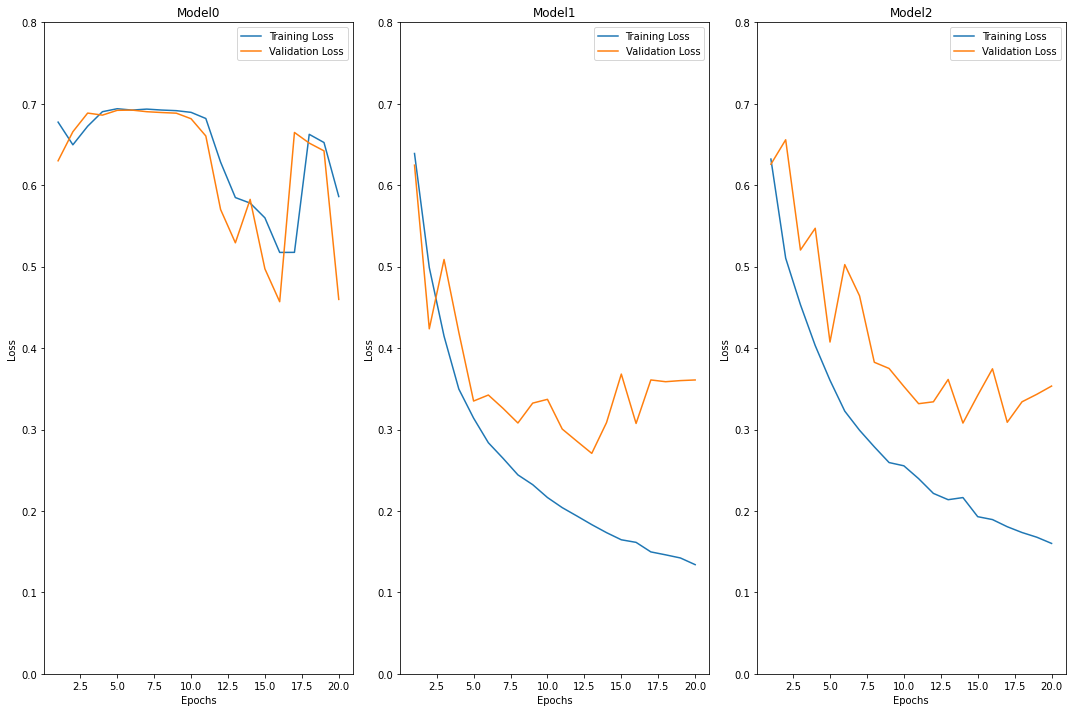

In [23]:
loss_plot([0,1,2],num_epoch)

### Model 2 vs Model 3 (effect of bidirection)

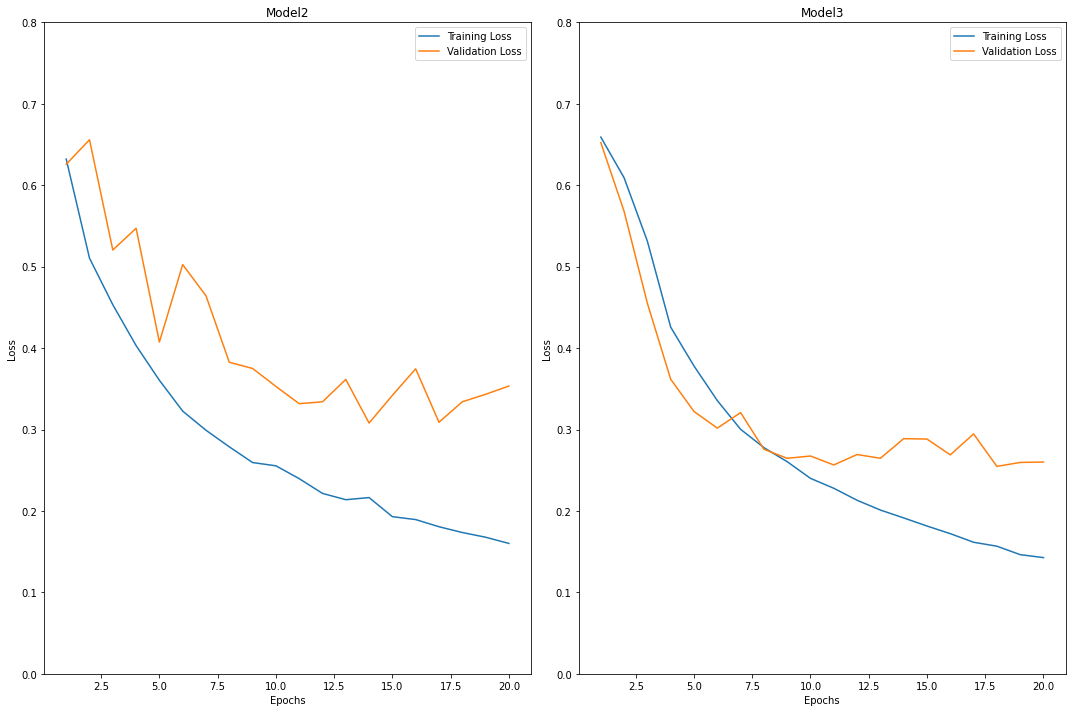

In [24]:
loss_plot([2,3],num_epoch)

### Model 2 vs Model 4 (effect of embedding)

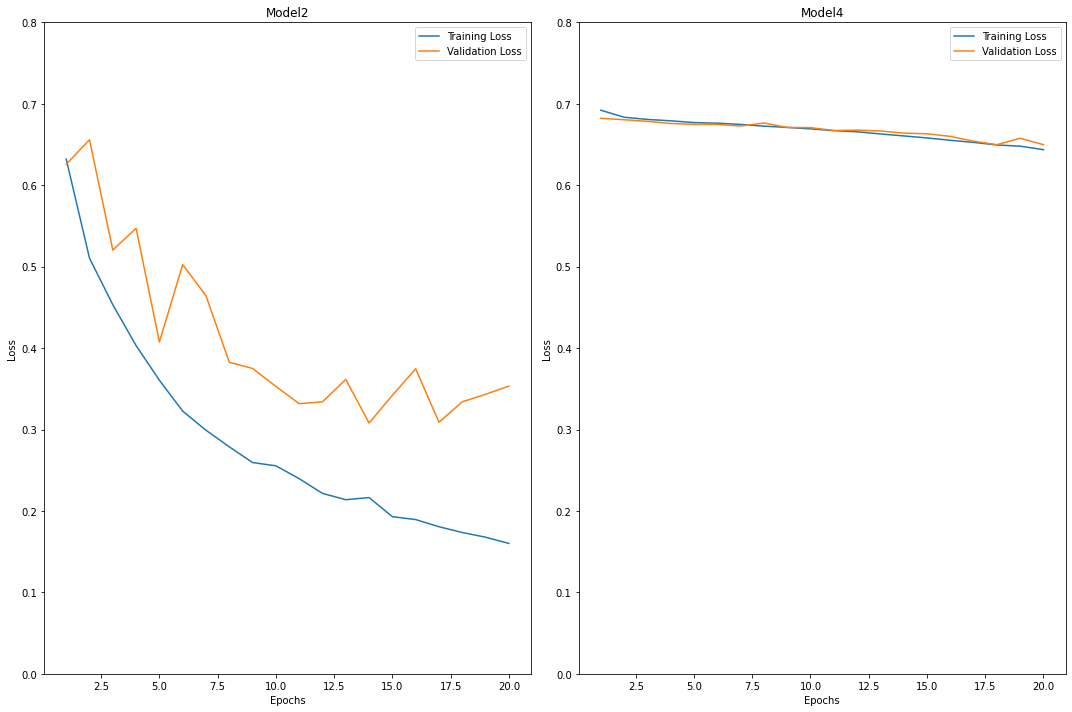

In [25]:
loss_plot([2,4],num_epoch)

### Test remaining models and rank performance

In [26]:
# Perform testing of remaining four models
for i in range(1,5):
    loss, acc = TEST(i, False)
    model_test_losses[i] = loss
    model_test_accs[i] = acc

# Sort the models by accuracy and report
sorted_model_test_acc = sorted(model_test_accs.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)
print("Performances of different models: \n")
for i, model in enumerate(sorted_model_test_acc):
    print("Rank {}: Model {} with test accuracy of {:.3f}".format(i+1, model[0], model[1]))

Performances of different models: 

Rank 1: Model 3 with test accuracy of 0.910
Rank 2: Model 1 with test accuracy of 0.906
Rank 3: Model 2 with test accuracy of 0.896
Rank 4: Model 0 with test accuracy of 0.800
Rank 5: Model 4 with test accuracy of 0.625


### Play with word embedding and observe distance 

In [36]:
embedd_model = model2

def predict_word_embedding(model, word):
    with torch.no_grad():
        model.eval()
        tokenized = word_tokenize(word)
        raw_integer = txt_field.vocab.stoi[tokenized[0]]
        tensorfied = torch.LongTensor([raw_integer]).unsqueeze(1).to(device)
        prediction = model.extract_embedding(tensorfied)
        return prediction.cpu().numpy().squeeze()

def predict_sentiment_val(model, word):
      with torch.no_grad():
        model.eval()
        tokenized = word_tokenize(word)
        raw_integer = txt_field.vocab.stoi[tokenized[0]]
        tensorfy = torch.LongTensor([raw_integer]).unsqueeze(1).to(device)
        prediction = model(tensorfy, torch.LongTensor([1])) # Single word has length 1
        return prediction.item()

def l2_distance(a, b):
    return np.mean(np.sqrt((a-b)**2)) 

good_val = predict_word_embedding(embedd_model, 'good')
happy_val = predict_word_embedding(embedd_model, 'happy')
bad_val = predict_word_embedding(embedd_model, 'bad')
boring_val = predict_word_embedding(embedd_model, 'boring')

good_sent = predict_sentiment_val(embedd_model, 'good')
happy_sent = predict_sentiment_val(embedd_model, 'happy')
bad_sent = predict_sentiment_val(embedd_model, 'bad')
boring_sent = predict_sentiment_val(embedd_model, 'boring')

print("Model 2 L2 distance of embeddings")
print("good vs happy: {:.3f}".format(l2_distance(good_val, happy_val)))
print("boring vs bad: {:.3f}".format(l2_distance(boring_val, bad_val)))
print("good vs boring: {:.3f}\n".format(l2_distance(good_val, boring_val)))

print("Model 2 Sentiment Values")
print("good: {:.3f}\nhappy: {:.3f}\nbad: {:.3f}\nboring: {:.3f}\n".format(good_sent,happy_sent,bad_sent,boring_sent))


Model 2 L2 distance of embeddings
good vs happy: 1.287
boring vs bad: 0.923
good vs boring: 1.404

Model 2 Sentiment Values
good: 0.624
happy: 0.637
bad: 0.188
boring: 0.162



### Preprocess reviews in submission.csv 

In [ ]:
predtxt_field = data.Field(tokenize=word_tokenize, lower=True, include_lengths=True, batch_first=True, stop_words = stop_words)
predlabel_field = data.Field(sequential=False, use_vocab=False, batch_first=True)

submit = TabularDataset(path=path+'submission.csv', format = 'csv', 
                            fields = [('label', predlabel_field),('text', txt_field)], 
                            skip_header = True)

submit_iter = BucketIterator(submit, batch_size=1, device = device, shuffle = False)

### Predict the labels and store in array

In [ ]:
# Fetch model with best performance
best_model = model_list[sorted_model_test_acc[0][0]]
best_model.eval()
label_list = []

with torch.no_grad():
    for entry in submit_iter:
        text, text_len = entry.text
        output = best_model(text,text_len).squeeze(1)
        label = 0 if output.item()<=0.5 else 1
        label_list.append(label)


### Fill in the labels and export new submission.csv

In [31]:
import pandas as pd
label_df = pd.read_csv(path+'submission.csv', sep=',')
label_df['label'] = label_list
display(label_df)
label_df.to_csv('20378582_p2.csv', index=False)

,label,text
0,0,Less self-conscious and much less pretentious ...
1,1,I thought that One Dark Night was great! It de...
2,0,I wish I had something more positive to say ab...
3,1,Easily 9 out of 10 for a film by director we w...
4,0,"One missed call, another Asian horror based on..."
...,...,...
1995,0,So umm this woman has a vagina that sucks peop...
1996,0,A sequel to actually a remake of Disney's 1996...
1997,1,Why can't more directors these days create hor...
1998,1,Turkish-German director Faith Ak n Head-On The...
